In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

from catboost import CatBoostClassifier
from category_encoders import TargetEncoder

import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

from tqdm import tqdm

from category_encoders import TargetEncoder

train, test = pd.read_csv('train_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251'), pd.read_csv('test_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['TARGET'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [2]:

data['duplicate'] = data.duplicated(subset = [i for i in data.columns if i != 'id_contract']) * 1
data.drop(['BIRTHDATE', 'id_contract'], axis=1, inplace=True)
data['SIGN_DATE'] = pd.to_datetime(data['SIGN_DATE'], format = '%d%b%Y:%H:%M:%S')
data['SIGN_DATE_day_of_week'] = data['SIGN_DATE'].apply(lambda x: x.day_of_week)
data['SIGN_DATE_day_of_year'] = data['SIGN_DATE'].apply(lambda x: x.day_of_year)
data['SIGN_DATE_days_in_month'] = data['SIGN_DATE'].apply(lambda x: x.days_in_month)
data['SIGN_DATE_week'] = data['SIGN_DATE'].apply(lambda x: x.week)
data['SIGN_DATE_month'] = data['SIGN_DATE'].apply(lambda x: x.month)
data['SIGN_DATE_year'] = data['SIGN_DATE'].apply(lambda x: x.year)
data['SIGN_DATE_value'] = data['SIGN_DATE'].apply(lambda x: x.value)
data.drop(['SIGN_DATE'], axis=1, inplace=True)
data['DATEFIRSTREG'] = pd.to_datetime(data['DATEFIRSTREG'], format = '%d%b%Y:%H:%M:%S')
data['DATEFIRSTREG_day_of_week'] = data['DATEFIRSTREG'].apply(lambda x: x.day_of_week)
data['DATEFIRSTREG_day_of_year'] = data['DATEFIRSTREG'].apply(lambda x: x.day_of_year)
data['DATEFIRSTREG_days_in_month'] = data['DATEFIRSTREG'].apply(lambda x: x.days_in_month)
data['DATEFIRSTREG_week'] = data['DATEFIRSTREG'].apply(lambda x: x.week)
data['DATEFIRSTREG_month'] = data['DATEFIRSTREG'].apply(lambda x: x.month)
data['DATEFIRSTREG_year'] = data['DATEFIRSTREG'].apply(lambda x: x.year)
data['DATEFIRSTREG_value'] = data['DATEFIRSTREG'].apply(lambda x: x.value)
data.drop(['DATEFIRSTREG'], axis=1, inplace=True)
data['TAXREG_REGDATE'] = pd.to_datetime(data['TAXREG_REGDATE'], format = '%d%b%Y:%H:%M:%S')
data['TAXREG_REGDATE_day_of_week'] = data['TAXREG_REGDATE'].apply(lambda x: x.day_of_week)
data['TAXREG_REGDATE_day_of_year'] = data['TAXREG_REGDATE'].apply(lambda x: x.day_of_year)
data['TAXREG_REGDATE_days_in_month'] = data['TAXREG_REGDATE'].apply(lambda x: x.days_in_month)
data['TAXREG_REGDATE_week'] = data['TAXREG_REGDATE'].apply(lambda x: x.week)
data['TAXREG_REGDATE_month'] = data['TAXREG_REGDATE'].apply(lambda x: x.month)
data['TAXREG_REGDATE_year'] = data['TAXREG_REGDATE'].apply(lambda x: x.year)
data['TAXREG_REGDATE_value'] = data['TAXREG_REGDATE'].apply(lambda x: x.value)
data.drop(['TAXREG_REGDATE'], axis=1, inplace=True)
data['TAXREGPAY_REGDATE'] = pd.to_datetime(data['TAXREGPAY_REGDATE'], format = '%d%b%Y:%H:%M:%S')
data['TAXREGPAY_REGDATE_day_of_week'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.day_of_week)
data['TAXREGPAY_REGDATE_day_of_year'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.day_of_year)
data['TAXREGPAY_REGDATE_days_in_month'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.days_in_month)
data['TAXREGPAY_REGDATE_week'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.week)
data['TAXREGPAY_REGDATE_month'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.month)
data['TAXREGPAY_REGDATE_year'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.year)
data['TAXREGPAY_REGDATE_value'] = data['TAXREGPAY_REGDATE'].apply(lambda x: x.value)
data.drop(['TAXREGPAY_REGDATE'], axis=1, inplace=True)
labelencoder = LabelEncoder()
data['OKFS_GROUP'] = labelencoder.fit_transform(data['OKFS_GROUP'])
data['OKOPF_GROUP'] = labelencoder.fit_transform(data['OKOPF_GROUP'])
data['OKOGU_GROUP'] = labelencoder.fit_transform(data['OKOGU_GROUP'])
data['WORKERSRANGE'] = labelencoder.fit_transform(data['WORKERSRANGE'])
data['OKVED_CODE'] = labelencoder.fit_transform(data['OKVED_CODE'])
data['CITIZENSHIP_NAME'] = labelencoder.fit_transform(data['CITIZENSHIP_NAME'])
data['SEX_NAME'] = labelencoder.fit_transform(data['SEX_NAME'])

data['SIGN_DATE_year_DATEFIRSTREG_year'] = data['SIGN_DATE_year'] - data['DATEFIRSTREG_year']
data['SIGN_DATE_year_TAXREG_REGDATE_year'] = data['SIGN_DATE_year'] - data['TAXREG_REGDATE_year']
data['SIGN_DATE_year_TAXREGPAY_REGDATE_year'] = data['SIGN_DATE_year'] - data['TAXREGPAY_REGDATE_year']
data['TAXREG_REGDATE_year_TAXREGPAY_REGDATE_year'] = data['TAXREG_REGDATE_year'] - data['TAXREGPAY_REGDATE_year']
data['DATEFIRSTREG_year_TAXREGPAY_REGDATE_year'] = data['DATEFIRSTREG_year'] - data['TAXREGPAY_REGDATE_year']
data['DATEFIRSTREG_year_TAXREG_REGDATE_year'] = data['DATEFIRSTREG_year'] - data['TAXREG_REGDATE_year']

#data['IS_NA_SUM'] = data.isna().sum(axis = 1).values

In [3]:
for i in data.columns:
    if data[i].isna().sum() >= 1:
        data[i+'_isNAN'] = pd.isna(data[i]).astype('uint8')

In [4]:
data.fillna(0, inplace = True)

In [5]:
for i in data.columns: 
    
    model=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1),max_features=1.0, n_jobs=-1)
    model.fit(data[[i]].values)

    data[i+'_IsolationForest'] = model.predict(data[[i]].values)
    

In [6]:
data.columns[(data.nunique() < 90) & (data.nunique() > 2)]

Index(['F1320', 'OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKATO_REGIONCODE',
       'OKATO_FED', 'OKTMO_FED', 'WORKERSRANGE', 'COUNTCOOWNERFCSM',
       'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL', 'COUNTBRANCH',
       'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'TELEPHONECOUNT',
       'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT',
       'PLAINTIFF_CASESNUMBER_YEAR', 'DEFENDANT_CASESNUMBER_YEAR',
       'THIRDOROTHERPERSON_YEAR', 'THIRDOROTHERPERSON_EVER',
       'NOTADMITTEDNUMBER_233_YEAR', 'NOTADMITTEDNUMBER_95_YEAR',
       'COUNT_CHANGE_YEAR', 'COUNT_CHANGE_EVER', 'AGE', 'SEX_NAME',
       'CITIZENSHIP_NAME', 'SIGN_DATE_day_of_week', 'SIGN_DATE_days_in_month',
       'SIGN_DATE_week', 'SIGN_DATE_month', 'DATEFIRSTREG_day_of_week',
       'DATEFIRSTREG_days_in_month', 'DATEFIRSTREG_week', 'DATEFIRSTREG_month',
       'DATEFIRSTREG_year', 'TAXREG_REGDATE_day_of_week',
       'TAXREG_REGDATE_days_in_month', 'TAXREG_REGDATE_week',
       'TAXREG_REGDATE_month',

In [7]:
data = pd.get_dummies(data, columns=[ 
    'F1320', 'OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKATO_REGIONCODE',
       'OKATO_FED', 'OKTMO_FED', 'WORKERSRANGE', 'COUNTCOOWNERFCSM',
       'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL', 'COUNTBRANCH',
       'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'TELEPHONECOUNT',
       'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT',
       'PLAINTIFF_CASESNUMBER_YEAR', 'DEFENDANT_CASESNUMBER_YEAR',
       'THIRDOROTHERPERSON_YEAR', 'THIRDOROTHERPERSON_EVER',
       'NOTADMITTEDNUMBER_233_YEAR', 'NOTADMITTEDNUMBER_95_YEAR',
       'COUNT_CHANGE_YEAR', 'COUNT_CHANGE_EVER', 'AGE', 'SEX_NAME',
       'CITIZENSHIP_NAME', 'SIGN_DATE_day_of_week', 'SIGN_DATE_days_in_month',
       'SIGN_DATE_week', 'SIGN_DATE_month', 'DATEFIRSTREG_day_of_week',
       'DATEFIRSTREG_days_in_month', 'DATEFIRSTREG_week', 'DATEFIRSTREG_month',
       'DATEFIRSTREG_year', 'TAXREG_REGDATE_day_of_week',
       'TAXREG_REGDATE_days_in_month', 'TAXREG_REGDATE_week',
       'TAXREG_REGDATE_month', 'TAXREG_REGDATE_year',
       'TAXREGPAY_REGDATE_day_of_week', 'TAXREGPAY_REGDATE_days_in_month',
       'TAXREGPAY_REGDATE_week', 'TAXREGPAY_REGDATE_month',
       'TAXREGPAY_REGDATE_year', 'SIGN_DATE_year_DATEFIRSTREG_year',
       'SIGN_DATE_year_TAXREG_REGDATE_year',
       'SIGN_DATE_year_TAXREGPAY_REGDATE_year',
       'TAXREG_REGDATE_year_TAXREGPAY_REGDATE_year',
       'DATEFIRSTREG_year_TAXREGPAY_REGDATE_year',
       'DATEFIRSTREG_year_TAXREG_REGDATE_year'], dummy_na=True)

In [8]:
data['F1410_F1510_F1300'] = (data['F1410'] + data['F1510']) / data['F1300']
data['F1410_F1510_F2330_F2330_F2320'] = (data['F1410'] + data['F1510']) / (data['F2330'] + data['F2330'] - data['F2320']) 
data['F1200_F1530_F1540'] = (data['F1200']) / (data['F1500'] - data['F1530'] - data['F1550'])
data['F1300_F1530_F1100_F1200'] = (data['F1300'] + data['F1530'] - data['F1100']) / data['F1200']
data['F2300_F2330_F2320_F2110'] = (data['F2300'] + data['F2330'] - data['F2320']) / data['F2110']
data['F1170_F1230_F1240_F1600'] = (data['F1170'] + data['F1230'] + data['F1240']) / data['F1600']
data['F1300_F1530_F1170'] = data['F1300'] + data['F1530'] - data['F1170'] 
data.fillna(0, inplace = True)

In [13]:
# data.to_csv('data_prepared_to_AI_11', index=False)
data.shape

(25221, 2169)

In [15]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace = True)

In [16]:
data.to_csv('data_prepared_to_AI_101', index=False)

In [250]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['TARGET'], axis=1)
#train_data = train_data.drop_duplicates(subset = [i for i in train_data.columns if i != 'id_contract']).reset_index(drop=True)

y = train_data['TARGET'].values            
X = train_data.drop(['TARGET'], axis=1)

In [251]:
X_train, X_test, y_train, y_test = X.iloc[:14000,], X.iloc[14000:,], y[:14000,], y[14000:,]

In [252]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, shuffle = False)

RF = lgb.LGBMClassifier(num_leaves=200, learning_rate=0.04, n_estimators=int(3000*1),
                                          colsample_bytree=0.5, subsample=0.5,
                                          n_jobs=-1, random_state=0)
RF.fit(X_train, y_train)

test_pred = RF.predict_proba(X_test)[:,1]
test_pred_bin = RF.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, test_pred)
auc = roc_auc_score(y_test, test_pred)
accuracy = accuracy_score(y_test, test_pred_bin)
f1 = f1_score(y_test, test_pred_bin)
precision =  precision_score(y_test, test_pred_bin)
recall = recall_score(y_test, test_pred_bin)

print('FP, TP              :', "%0.2f" % sum(fpr), "%0.2f" % sum(tpr))
print('ROC_AUC_SCORE       :', "%0.2f" % auc)
print('accuracy            :', "%0.2f" % accuracy)
print('precision           :', "%0.2f" % precision)
print('recall              :', "%0.2f" % recall)
print('f1                  :', "%0.2f" % f1)

print('val, train  AUC     :', "%0.2f" % roc_auc_score(y_test, test_pred), "%0.2f" % roc_auc_score(y_train, RF.predict_proba(X_train)[:,1]))
print('val, train  AUC_2   :', "%0.2f" % roc_auc_score(y_test, test_pred_bin), "%0.2f" % roc_auc_score(y_train, RF.predict(X_train)))
print(confusion_matrix(y_test, test_pred_bin))
print(classification_report(y_test, RF.predict(X_test)))

FP, TP              : 119.77 556.81
ROC_AUC_SCORE       : 0.95
accuracy            : 0.87
precision           : 0.93
recall              : 0.69
f1                  : 0.79
val, train  AUC     : 0.95 1.00
val, train  AUC_2   : 0.83 1.00
[[2423   74]
 [ 439  955]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2497
           1       0.93      0.69      0.79      1394

    accuracy                           0.87      3891
   macro avg       0.89      0.83      0.85      3891
weighted avg       0.88      0.87      0.86      3891



In [253]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, shuffle = False)

RF = RandomForestClassifier( n_jobs=-1, random_state=0)
RF.fit(X_train, y_train)

test_pred = RF.predict_proba(X_test)[:,1]
test_pred_bin = RF.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, test_pred)
auc = roc_auc_score(y_test, test_pred)
accuracy = accuracy_score(y_test, test_pred_bin)
f1 = f1_score(y_test, test_pred_bin)
precision =  precision_score(y_test, test_pred_bin)
recall = recall_score(y_test, test_pred_bin)

print('FP, TP              :', "%0.2f" % sum(fpr), "%0.2f" % sum(tpr))
print('ROC_AUC_SCORE       :', "%0.2f" % auc)
print('accuracy            :', "%0.2f" % accuracy)
print('precision           :', "%0.2f" % precision)
print('recall              :', "%0.2f" % recall)
print('f1                  :', "%0.2f" % f1)

print('val, train  AUC     :', "%0.2f" % roc_auc_score(y_test, test_pred), "%0.2f" % roc_auc_score(y_train, RF.predict_proba(X_train)[:,1]))
print('val, train  AUC_2   :', "%0.2f" % roc_auc_score(y_test, test_pred_bin), "%0.2f" % roc_auc_score(y_train, RF.predict(X_train)))
print(confusion_matrix(y_test, test_pred_bin))
print(classification_report(y_test, RF.predict(X_test)))

/home/atp/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [254]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, shuffle = False)
scale_pos_weight = sum(y_train == 0) / (1.0 * sum(y_train == 1))

RF_T = CatBoostClassifier(
      verbose=0
    #loss_function='Logloss'
)
RF_T.fit(X_train, y_train)

test_pred = RF_T.predict_proba(X_test)[:,1]
test_pred_bin = RF_T.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, test_pred)
auc = roc_auc_score(y_test, test_pred)
accuracy = accuracy_score(y_test, test_pred_bin)
f1 = f1_score(y_test, test_pred_bin)
precision =  precision_score(y_test, test_pred_bin)
recall = recall_score(y_test, test_pred_bin)

print('FP, TP              :', "%0.2f" % sum(fpr), "%0.2f" % sum(tpr))
print('ROC_AUC_SCORE       :', "%0.2f" % auc)
print('accuracy            :', "%0.2f" % accuracy)
print('precision           :', "%0.2f" % precision)
print('recall              :', "%0.2f" % recall)
print('f1                  :', "%0.2f" % f1)

print('val, train  AUC     :', "%0.2f" % roc_auc_score(y_test, test_pred), "%0.2f" % roc_auc_score(y_train, RF_T.predict_proba(X_train)[:,1]))
print('val, train  AUC_2   :', "%0.2f" % roc_auc_score(y_test, test_pred_bin), "%0.2f" % roc_auc_score(y_train, RF_T.predict(X_train)))

print(confusion_matrix(y_test, test_pred_bin))
print(classification_report(y_test, RF_T.predict(X_test)))

FP, TP              : 149.22 620.90
ROC_AUC_SCORE       : 0.95
accuracy            : 0.88
precision           : 0.91
recall              : 0.74
f1                  : 0.81
val, train  AUC     : 0.95 0.99
val, train  AUC_2   : 0.85 0.94
[[2392  105]
 [ 365 1029]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2497
           1       0.91      0.74      0.81      1394

    accuracy                           0.88      3891
   macro avg       0.89      0.85      0.86      3891
weighted avg       0.88      0.88      0.88      3891



In [257]:

cv = KFold(n_splits=10, random_state=42, shuffle=True)
pred = []
classifiers = []
# метод split возвращает индексы для объектов train и test
for train_index, test_index in cv.split(train_data['TARGET']):
    #RF = RandomForestClassifier(n_estimators=300, max_depth=39, n_jobs=-1, random_state=0)
    #extra_tree = ExtraTreeClassifier(random_state=0)
    #neigh = KNeighborsClassifier(n_neighbors=3)
    #XGB = XGBClassifier(use_label_encoder =False, eval_metric='mlogloss')
    #GBCl = GradientBoostingClassifier()
    
    
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = train_data['TARGET'][train_index], train_data['TARGET'][test_index]
    scale_pos_weight = sum(y_train == 0) / (1.0 * sum(y_train == 1))
    #clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
    clf = CatBoostClassifier(
      verbose=0
    #loss_function='Logloss'
)
    clf.fit(X_train, y_train)
    #BC = BaggingClassifier(clf, random_state=13, n_jobs=-1).fit(X_train, y_train)
    #ETREE = extra_tree.fit(X_train, y_train)
   # neigh_ = neigh.fit(X_train, y_train)
    #XGB_ = XGB.fit(X_train, y_train)
    #GBCl_ = GBCl.fit(X_train, y_train)
    
    #print('BaggingClassifier: ', roc_auc_score(y_test, BC.predict(X_test)))
    #print('CatBoostClassifier ', roc_auc_score(y_test, clf.predict(X_test)))
    print('RandomForestClassifier ', roc_auc_score(y_test, clf.predict(X_test)))
    print (accuracy_score(y_test, clf.predict(X_test)))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    #print('ExtraTreeClassifier ', roc_auc_score(y_test, ETREE.predict(X_test)))
    #print('KNeighborsClassifier ', roc_auc_score(y_test, neigh_.predict(X_test)))
    #print('XGB ', roc_auc_score(y_test, XGB_.predict(X_test)))
    #print('GradientBoostingClassifier ', roc_auc_score(y_test, GBCl_.predict(X_test)))
    
    print('')
 
    # получим 5 оптимальных классификаторов
    classifiers.append(clf)
    pred += [clf.predict_proba(test_data)[:,1]]

RandomForestClassifier  0.8871950267095686
0.8949720670391061
[[996  80]
 [108 606]]

RandomForestClassifier  0.8843550323355147
0.8921185019564002
[[978  76]
 [117 618]]

RandomForestClassifier  0.9011819913366717
0.9083286752375629
[[978  54]
 [110 647]]

RandomForestClassifier  0.8916533252013926
0.8971492453884852
[[943  66]
 [118 662]]

RandomForestClassifier  0.883346063807046
0.8921185019564002
[[997  79]
 [114 599]]

RandomForestClassifier  0.8895480074681684
0.8954723309111235
[[951  70]
 [117 651]]

RandomForestClassifier  0.8875744870674206
0.8965902738960313
[[987  64]
 [121 617]]

RandomForestClassifier  0.8956746080509559
0.8999441028507547
[[953  79]
 [100 657]]

RandomForestClassifier  0.8922724244884365
0.9010620458356624
[[1004   68]
 [ 109  608]]

RandomForestClassifier  0.8995300813220379
0.9055338177752935
[[1002   77]
 [  92  618]]



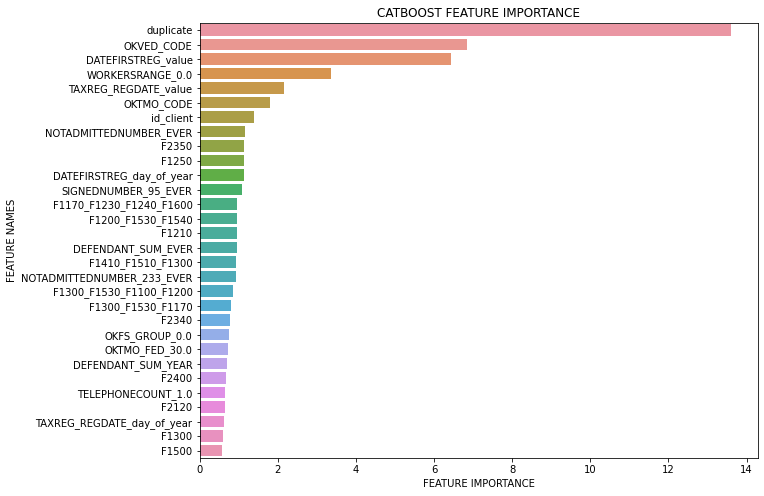

In [256]:

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:30], y=fi_df['feature_names'][:30])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(RF_T.get_feature_importance(),X_test.columns,'CATBOOST')


In [258]:
test['TARGET'] = pd.DataFrame(pred).T.mean(axis=1)
test[['id_contract', 'TARGET']].to_csv('submit_file_CB_2.csv', sep=';', index=False)
test[['id_contract', 'TARGET']].head()

,id_contract,TARGET
0,17892,0.029051
1,17893,0.072784
2,17894,0.090004
3,17895,0.509014
4,17896,0.767849


In [83]:
fi_df={'feature_names':X_test.columns,'feature_importance':RF_T.get_feature_importance()}
fi_df = pd.DataFrame(fi_df)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

In [88]:
data_30 = data[fi_df['feature_names'][:30].values]
data_30['sample'] = data['sample'].values
data_30['TARGET'] = data['TARGET'].values
data_30.to_csv('30.csv', index=False)

<ipython-input-88-6526a6797c28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_30['sample'] = data['sample'].values
<ipython-input-88-6526a6797c28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_30['TARGET'] = data['TARGET'].values


In [89]:
kmeans_model = KMeans(n_clusters=10).fit(data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [230]:
model=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(data[['SIGN_DATE_days_in_month']])

IsolationForest(contamination=0.1)

In [231]:
model.decision_function(data[['SIGN_DATE_days_in_month']])

array([0.03229011, 0.03229011, 0.03229011, ..., 0.03229011, 0.03229011,
       0.03229011])

In [232]:
sum(model.predict(data[['SIGN_DATE_days_in_month']]) > 0)

23203

In [224]:
data.corr('TARGET', model.predict(data) > 0)

ValueError: method must be either 'pearson', 'spearman', 'kendall', or a callable, 'TARGET' was supplied

In [227]:
data['TARGET'].corr(pd.Series(model.predict(data) > 0))

0.09543511878182737